<a href="https://colab.research.google.com/github/gabrielvinicios02/ExperimentsMultivariate/blob/f-DuasBases/ClassificadorXGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Séries Temporais


<center>
<table><tr><td> <a href="http://www.minds.eng.ufmg.br/"><img src="https://github.com/petroniocandido/pyFTS/raw/master/img/minds_logo_medium.jpeg" alt="MINDS - Machine Intelligence and Data Science Lab" width="100"/></a></td> 
  <td>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;</td>
<td><a href="https://pyfts.github.io/pyFTS/"><img src="https://github.com/petroniocandido/pyFTS/raw/master/img/logo_medium.png" alt="pyFTS - Fuzzy Time Series for Python" width="100"/></a></td>
</tr>
</table>
</center>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt

In [ ]:
dataset = pd.read_excel('../content/sample_data/Base.xlsx')
x = dataset.iloc[:,:-1].values
y = dataset.iloc[:,-1].values

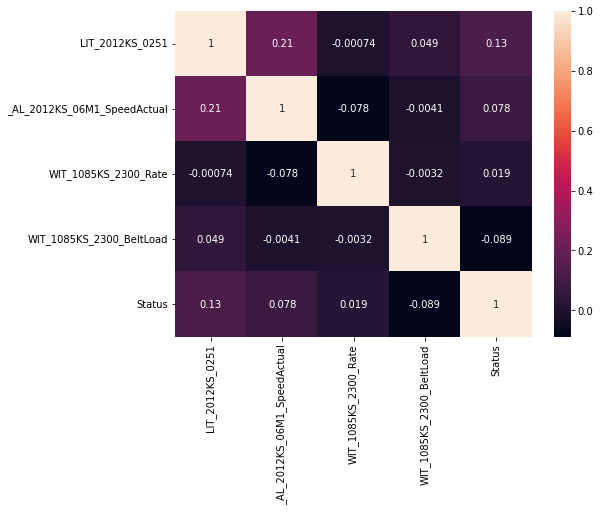

In [ ]:
import seaborn as sns
dataset2 = pd.read_excel('../content/sample_data/Base.xlsx')
corr_df = dataset2.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.show()

In [ ]:
print(dataset2)

      LIT_2012KS_0251  ...  Status
0           25.444870  ...       1
1           24.390213  ...       1
2           22.518898  ...       1
3           30.281023  ...       1
4           48.265495  ...       1
...               ...  ...     ...
6313         2.114453  ...       0
6314         2.566652  ...       0
6315         3.876476  ...       0
6316         3.395008  ...       0
6317         3.202985  ...       0

[6318 rows x 5 columns]


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x , y, test_size = 0.2, random_state = 10)

In [ ]:
from xgboost import XGBClassifier
Classifier = XGBClassifier()
Classifier.fit(x_train, y_train)

XGBClassifier()

Matriz de confusão

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
ypred = Classifier.predict(x_test)
cm = confusion_matrix(y_test, ypred)
print(cm)

[[281 197]
 [ 65 721]]


Precisão

In [ ]:
accuracy_score(y_test, ypred)

0.7927215189873418

In [ ]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = Classifier, X = x_train, y = y_train, cv = 10)

print(accuracies.mean()*100)
print(accuracies.std()*100)

79.20349861073063
1.6023111356796393
